In [1]:
import dgl.nn as dglnn
import dgl
import math
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from collections import defaultdict
import torch.nn.init as init
from dgl.nn.functional import edge_softmax

In [2]:
data = pd.read_csv('../NF-CSE-CIC-IDS2018.csv')

In [3]:
data = data.groupby(by='Attack').sample(frac=0.1, random_state=13)

In [4]:
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)
# data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
# data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
#data

In [5]:
len(data.Attack.value_counts())

15

In [6]:
data.Attack.unique()

array(['Benign', 'Bot', 'Brute Force -Web', 'Brute Force -XSS',
       'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP',
       'DDoS attacks-LOIC-HTTP', 'DoS attacks-GoldenEye',
       'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest',
       'DoS attacks-Slowloris', 'FTP-BruteForce', 'Infilteration',
       'SQL Injection', 'SSH-Bruteforce'], dtype=object)

In [7]:
#data = data.groupby(by='Attack').sample(frac=0.15, random_state=13)

In [8]:
# b = []
# for i in range(len(data)):
#     if data['Attack'][i] in ['DDoS attacks-LOIC-HTTP', 'DDOS attack-LOIC-UDP', 'DDOS attack-HOIC']:
#         b.append(i)

In [9]:
# c = []
# for i in range(len(data)):
#     if data['Attack'][i] in ['DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'DoS attacks-GoldenEye','DoS attacks-Slowloris']:
#         c.append(i)

In [10]:
# d = []
# for i in range(len(data)):
#     if data['Attack'][i] in ['FTP-BruteForce', 'SSH-Bruteforce']:
#         d.append(i)

In [11]:
'''a = []
for i in range(len(data)):
    if data['Attack'][i] in ['SQL Injection', 'Brute Force -Web', 'Brute Force -XSS','DDOS attack-HOIC','DDOS attack-LOIC-UDP']:
        a.append(i)
    '''

"a = []\nfor i in range(len(data)):\n    if data['Attack'][i] in ['SQL Injection', 'Brute Force -Web', 'Brute Force -XSS','DDOS attack-HOIC','DDOS attack-LOIC-UDP']:\n        a.append(i)\n    "

In [12]:
# data.loc[b, 'Attack'] = 'DDoS'
# data.loc[c, 'Attack'] = 'DoS'
# data.loc[d, 'Attack'] = 'BruteForce
#data.drop(index=a, axis=1, inplace=True)

In [13]:
data.drop(columns=['Label'],inplace = True)
data.rename(columns={"Attack": "label"},inplace = True)
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])
label = data.label
data.drop(columns=['label'],inplace = True)
scaler = StandardScaler()
#scaler = MinMaxScaler()
data =  pd.concat([data, label], axis=1)
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
4651367,172.31.64.42,172.25.145.142,17,5.126,72,100,1,1,0,4294966,0
2244262,172.31.68.19,172.21.142.174,17,0.000,64,80,1,1,0,4294967,0
4036695,172.31.66.94,172.28.197.110,17,5.119,62,107,1,1,0,4294965,0
4268024,172.31.67.41,172.24.140.224,17,0.000,65,81,1,1,0,4294966,0
741963,172.31.65.39,172.27.201.84,6,91.126,914,4882,10,9,218,4294457,0
...,...,...,...,...,...,...,...,...,...,...,...
8271095,13.58.98.64,172.29.176.219,6,0.000,3012,0,21,0,27,0,14
8257955,13.58.98.64,172.29.233.254,6,0.000,3220,0,25,0,27,0,14
8283161,13.58.98.64,172.22.230.9,6,0.000,3164,0,23,0,27,0,14
8255043,13.58.98.64,172.20.166.36,6,0.000,3212,0,23,0,27,0,14


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    data,label, test_size=0.3, random_state=123,stratify= label)

In [15]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [16]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

X_train['h'] = X_train[ cols_to_norm ].values.tolist()
#X_train

In [17]:
#X_train = X_train.sort_values(by=['IPV4_DST_ADDR'])
#X_train = X_train.reset_index(drop=True)

In [18]:
g_len = 55000
g_num = math.ceil(len(X_train)/g_len)

In [19]:
g_num

11

In [20]:
#seed = 39788
learning_rate =  0.0001
num = 10000
k1 = 15
tau = 5
num_epochs =  300
weight_decay = 0.00001

In [21]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [22]:
class GATlayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(GATlayer,self).__init__()
    
        self.n_feat = n_feat
        self.e_feat = e_feat
        self.out_feat = out_feat
        self.num_heads = num_heads
        self.W_msg = nn.Linear(2 * n_feat + e_feat, out_feat)
        self.W = nn.Linear(2 * n_feat + e_feat, 2 * out_feat)
 
        self.a = nn.Parameter(torch.rand(size=(2 * out_feat  , 1)))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        
        gain = math.sqrt(2)
        init.xavier_normal_(self.W.weight, gain=gain)

        init.xavier_normal_(self.a, gain=gain)
    
    def edge_attention(self, edges):        
        
        feat_cat = torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)
        
        w_feat_cat = self.W(feat_cat)
                
        #e = F.leaky_relu(torch.matmul(w_feat_cat, self.a[i]))
                              
        return {'e': F.leaky_relu(torch.matmul(w_feat_cat, self.a))}
        
#     def message_func(self, edges):
#         return {'h': self.W_msg(torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)) , 'e': edges.data['e']}
    
    def message_func(self, edges):
        return {'h': self.W_msg(torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)) , 'x': edges.data['x']}
  
    
    def reduce_func(self, nodes):
        
#         attention = F.softmax(nodes.mailbox['e'] ,dim = 1)
#         h = (attention * nodes.mailbox['h']).sum(1)
        h = (nodes.mailbox['x'] * nodes.mailbox['h']).sum(1)
        return {'h': h}
    
    def forward(self, g, n_feat, e_feat):
        with g.local_scope():
            
            g.ndata['h'] = n_feat
            
            g.edata['h'] = e_feat
            g.apply_edges(self.edge_attention)
            #attention = edge_softmax(g, edges.data['e'] ,norm_by='src')
            attention = edge_softmax(g, g.edata['e'])
            g.edata['x'] = attention
            g.update_all(self.message_func, self.reduce_func)
            g.ndata['h'] = F.relu(g.ndata['h'])
            feat = g.ndata['h']
                
            return feat
        
class MultiHeadGATLayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATlayer(n_feat, e_feat, out_feat, num_heads))
        
    def forward(self,g, h, e_feat):
        
        out_feat = [attn_head(g, h, e_feat) for attn_head in self.heads]
    
        out_feat = torch.cat(out_feat,dim = 1).reshape(g.num_nodes(),len(self.heads), -1)

        return out_feat.mean(1)

class GAT(nn.Module):
    def __init__(self, in_dim, e_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer( in_dim, e_dim, 8, num_heads)
#         self.layer1 = MultiHeadGATLayer( in_dim, e_dim, 16, num_heads)
#         self.layer2 = MultiHeadGATLayer( 16, e_dim, out_dim, 1)
        
    def forward(self, g, h, e_feat):
        h = self.layer1(g, h, e_feat)
#         h = F.dropout(h,p = 0.2)
#         h = self.layer2(g, h, e_feat)
        g.ndata['h'] = h
        return h , g

In [23]:
class Genetation(torch.nn.Module):
    def __init__(self, in_feat, out_feat, num_heads, activation):
        super(Genetation, self).__init__()
        self.conv = GATConv(in_feat, out_feat, num_heads)
        self.activation = activation

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, g, feat):
        x = self.activation(self.conv(g, feat))
        #x = self.conv(g, feat)
        g.ndata['h'] = x
        return x.mean(1) ,g

In [24]:
import random
def sub_sam(nodes, adj_lists, k):
    node_neighbor =  [ [] for i in range(nodes.shape[0])]
    node_neighbor_cen =  [ [] for i in range(nodes.shape[0])]
    node_centorr =  [[] for i in range(nodes.shape[0])]

    num_nei = 0

    for node in nodes:
        neighbors = set([int(node)])
        neighs = adj_lists[int(node)]
        node_centorr[num_nei] = [int(node)]
        current1 = adj_lists[int(node)]
        if len(neighs) >= k:
            neighs -= neighbors
            current1 = random.sample(neighs, k-1)

            node_neighbor[num_nei] = [neg_node for neg_node in current1]
            current1.append(int(node))
            node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]
            num_nei += 1

        node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]

    node_neighbor_cen = [neighbors for neighbors in node_neighbor_cen if neighbors]
    node_neighbor_cen  = node_neighbor_cen[:-1]
    return node_neighbor_cen

In [25]:
class Model(nn.Module):
    def __init__(self,  Encoder, gene, tau = 0.5):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.tau: float = tau
        self.ge = gene

    def forward(self, graph, node_feats, edge_feats) :
        z, g1 = self.encoder(graph,node_feats,edge_feats)
        #z_g, g2 = self.ge(graph,z)
        z_g, g2 = self.ge(graph,z,edge_feats)
        return z, z_g, g1, g2
    
    def embed(self, graph, node_feats, edge_feats):
        z,_ = self.encoder(graph, node_feats, edge_feats)
        return z

    def loss(self, z1, z2, adj, sub_g1, g1, g2):
        loss = self.sub_loss_batch(z1, z2, adj, sub_g1, g1, g2)
        return loss

    def sub_loss_batch(self, z, z_g, adj, sub_g1, g1, g2):
        subz_s, sub_gene_s = self.subg_centor(z, z_g, sub_g1)

        num = th.randint(0, len(sub_g1)-1, [len(sub_g1),])
        if num[0] == 0:
            num[0] = 1
        for i in range(1, len(num)):
            if num[i] == i:
                num[i] -= 1
        subg2_s_n = subz_s[num] # disrupt
        sub_gene_s_n = sub_gene_s[num]
        #print('sub_gene_s',sub_gene_s.shape)
        #print('sub_gene_s_n',sub_gene_s_n.shape)

        input1 = th.cat((subz_s, subz_s, subz_s), dim=0)
        input2 = th.cat((sub_gene_s, subg2_s_n, sub_gene_s_n), dim=0)
        
        edges1, edges2 = self.edges_f(g1, g2, sub_g1, z, z_g)
        #print('edges2',edges2.shape)
        subg2_se = edges1[num]
        sub_gene_s_e = edges2[num]
        #print('sub_gene_s_e',sub_gene_s_e.shape)
        input1_edges = th.cat((edges1, edges1, edges1), dim=0)
        input2_edges = th.cat((edges2, subg2_se, sub_gene_s_e), dim=0)
        input1_edges = input1_edges.requires_grad_(True)
        input2_edges = input2_edges.requires_grad_(True)
        
        # adj
        subg1_adj = self.sub_adj(adj, sub_g1)
        input_adj = th.cat((subg1_adj, subg1_adj, subg1_adj), dim=0)
        
        lbl_1 = th.ones(len(sub_g1)).cuda()
        lbl_2 = th.zeros(len(sub_g1)*2).cuda()
        lbl = th.cat((lbl_1, lbl_2), 0).cuda()
        
        lbl_1_e = th.ones(len(edges2) ).cuda()
        lbl_2_e = th.zeros(len(edges2)* 2).cuda()
        lbl_e = th.cat((lbl_1_e, lbl_2_e), 0).cuda()
        
         # WD
        wd, T_wd = self.wd(input1, input2, self.tau)
        logits = th.exp(-wd / 0.01)
        loss1 = b_xent(th.squeeze(logits), lbl)
        #print('loss1', loss1)
        
        # GWD
        gwd = self.gwd(input1.transpose(2,1), input2.transpose(2,1), T_wd, input_adj, self.tau)
        logits2 = th.exp(-gwd / 0.1)
        loss2 = b_xent(th.squeeze(logits2), lbl)
        #print('loss2',loss2)
        

        wd, T_wd = self.wd(input1_edges, input2_edges, self.tau)
        logits3 = th.exp(-wd / 0.01)
        loss3 = b_xent(th.squeeze(logits3), lbl_e)
        #print('loss3', loss3)


        loss = 0.7 * loss3 + 0.3 * loss2
        #loss = 0.6 * loss3 + 0.4 * loss1 
        return loss
    
    def edges_f (self,g1,g2,sub_g1, z, z_g):
        edge_feat_1 = [[] for i in range(len(sub_g1))]
        edge_feat_2 = [[] for i in range(len(sub_g1))]
        sc = MLPPredictor(g1.edata['h'].shape[1],8).cuda()
        z_e = sc(g1, z)
        z_ge = sc(g2, z_g)
        for i in range(len(sub_g1)):
            cen_node = sub_g1[i][-1]
            dst = sub_g1[i][:-1]
            src_node_id = cen_node

            for j in dst:
                dst_node_id = j

                edge_indices = g1.edge_ids(src_node_id, dst_node_id,return_uv = True)

                edge_feature_1 = torch.Tensor(z_e[edge_indices[2]]).float().tolist()
                edge_feature_2 = torch.Tensor(z_ge[edge_indices[2]]).float().tolist()

                edge_feat_1.append(edge_feature_1)
                edge_feat_2.append(edge_feature_2)
                if len(edge_feat_1[-1]) == 2:
                    edge_feat_1[-1] = [edge_feat_1[-1][0]]
                    edge_feat_2[-1] = [edge_feat_2[-1][0]]
                
        edge_feat_1 = [neighbors for neighbors in edge_feat_1 if neighbors]
        edge_feat_2 = [neighbors for neighbors in edge_feat_2 if neighbors]
        edge_feat_1 = torch.Tensor(edge_feat_1)
#         print('edge_feat_1',edge_feat_1)
        edge_feat_2 = torch.Tensor(edge_feat_2)
        edge_feat_1 = edge_feat_1.reshape(len(sub_g1),-1, 8)
        edge_feat_2 = edge_feat_2.reshape(len(sub_g1),-1, 8)
        return edge_feat_1, edge_feat_2
    
    def sub_adj(self, adj, sub_g1):
        subg1_adj = th.zeros(len(sub_g1), len(sub_g1[0]), len(sub_g1[0]))
        for i in range(len(sub_g1)):
            subg1_adj[i] = adj[sub_g1[i]].t()[sub_g1[i]]
        return subg1_adj


    def subg_centor(self, z, z_g, sub_g1):
        sub = [element for lis in sub_g1 for element in lis]
        subz = z[sub] 
        subg = z_g[sub]

        sub_s = subz.reshape(len(sub_g1), len(sub_g1[0]), -1)
        subg_s = subg.reshape(len(sub_g1), len(sub_g1[0]), -1)
        return sub_s, subg_s

    # WD
    def wd(self, x, y, tau):
        cos_distance = self.cost_matrix_batch(th.transpose(x, 2, 1), th.transpose(y, 2, 1), tau)
        cos_distance = cos_distance.transpose(1,2)

        beta = 0.1
        min_score = cos_distance.min()
        max_score = cos_distance.max()
        threshold = min_score + beta * (max_score - min_score)
        cos_dist = nn.functional.relu(cos_distance - threshold)
        
        wd, T_wd = self.OT_distance_batch(cos_dist, x.size(0), x.size(1), y.size(1), 40)
        return wd, T_wd

    def OT_distance_batch(self, C, bs, n, m, iteration=50):
        C = C.float().cuda()
        T = self.OT_batch(C, bs, n, m, iteration=iteration)
        temp = th.bmm(th.transpose(C,1,2), T)
        distance = self.batch_trace(temp, m, bs)
        return distance, T
    
    def OT_batch(self, C, bs, n, m, beta=0.5, iteration=50):
        sigma = th.ones(bs, int(m), 1).cuda()/float(m)
        T = th.ones(bs, n, m).cuda()
        A = th.exp(-C/beta).float().cuda()
        for t in range(iteration):
            Q = A * T
            for k in range(1):
                delta = 1 / (n * th.bmm(Q, sigma))
                a = th.bmm(th.transpose(Q,1,2), delta)
                sigma = 1 / (float(m) * a)
            T = delta * Q * sigma.transpose(2,1)
        return T

    def cost_matrix_batch(self, x, y, tau=0.5):
        bs = list(x.size())[0]
        D = x.size(1)
        assert(x.size(1)==y.size(1))
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)
        
        cos_dis = th.bmm(th.transpose(x, 1, 2), y)
        cos_dis = th.exp(- cos_dis / tau)
        return cos_dis.transpose(2,1)

    def batch_trace(self, input_matrix, n, bs):
        a = th.eye(n).cuda().unsqueeze(0).repeat(bs, 1, 1)
        b = a * input_matrix
        return th.sum(th.sum(b,-1),-1).unsqueeze(1)
    
    
    # GWD
    def gwd(self, X, Y, T_wd, input_adj, tau, lamda=1e-1, iteration=5, OT_iteration=20):
        m = X.size(2)
        n = Y.size(2)
        bs = X.size(0)
        p = (th.ones(bs, m, 1)/m).cuda()
        q = (th.ones(bs, n, 1)/n).cuda()
        return self.GW_distance(X, Y, p, q, T_wd, input_adj, tau, lamda=lamda, iteration=iteration, OT_iteration=OT_iteration)

    def GW_distance(self, X, Y, p, q, T_wd, input_adj, tau, lamda=0.5, iteration=5, OT_iteration=20):
        cos_dis = th.exp(- input_adj / tau).cuda() 
        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        Cs = nn.functional.relu(res.transpose(2,1))

        Ct = self.cos_batch(Y, Y, tau).float().cuda()
        bs = Cs.size(0)
        m = Ct.size(2)
        n = Cs.size(2)
        T, Cst = self.GW_batch(Cs, Ct, bs, n, m, p, q, beta=lamda, iteration=iteration, OT_iteration=OT_iteration)
        temp = th.bmm(th.transpose(Cst,1,2), T_wd)
        distance = self.batch_trace(temp, m, bs)
        return distance

    def GW_batch(self, Cs, Ct, bs, n, m, p, q, beta=0.5, iteration=5, OT_iteration=20):
        one_m = th.ones(bs, m, 1).float().cuda()
        one_n = th.ones(bs, n, 1).float().cuda()

        Cst = th.bmm(th.bmm(Cs**2, p), th.transpose(one_m, 1, 2)) + \
            th.bmm(one_n, th.bmm(th.transpose(q,1,2), th.transpose(Ct**2, 1, 2)))
        gamma = th.bmm(p, q.transpose(2,1))
        for i in range(iteration):
            C_gamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
            gamma = self.OT_batch(C_gamma, bs, n, m, beta=beta, iteration=OT_iteration)
        Cgamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
        return gamma.detach(), Cgamma

    def cos_batch(self, x, y, tau):
        bs = x.size(0)
        D = x.size(1)
        assert(x.size(1)==y.size(1))
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)
        cos_dis = th.bmm(th.transpose(x,1,2), y)
        cos_dis = th.exp(- cos_dis / tau).transpose(1,2)
        
        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        return nn.functional.relu(res.transpose(2,1))

In [26]:
def train(model, g,node_feats,edge_feats, adj, node_neighbor_cen):
    model.train()
    optimizer.zero_grad()

    z1, z2, g1, g2 = model(g, node_feats, edge_feats)
    loss = model.loss(z1, z2, adj, node_neighbor_cen, g1, g2)
    #loss.requires_grad_(True)
    loss.backward(retain_graph=True)
    optimizer.step()

    return loss.item()

In [27]:
%%time
graph = []
for i in range(g_num):
    G = X_train[ i*g_len: (i+1)* g_len ]
    G = nx.from_pandas_edgelist(G, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
    G = G.to_directed()
    G = from_networkx(G,edge_attrs=['h','label'] )
    graph.append(G)

CPU times: user 22.4 s, sys: 532 ms, total: 22.9 s
Wall time: 22.9 s


In [28]:
#plt.rcParams["figure.figsize"] = (50,50)
#nx.draw(graph[0],node_size=10)

In [29]:
len(graph),graph,len(graph)

(11,
 [Graph(num_nodes=57447, num_edges=110000,
        ndata_schemes={}
        edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}),
  Graph(num_nodes=57224, num_edges=110000,
        ndata_schemes={}
        edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}),
  Graph(num_nodes=57428, num_edges=110000,
        ndata_schemes={}
        edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}),
  Graph(num_nodes=57308, num_edges=110000,
        ndata_schemes={}
        edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}),
  Graph(num_nodes=57229, num_edges=110000,
        ndata_schemes={}
        edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}),
  Graph(num_nodes=57303, num_edges=110000,
        ndata_schemes={}
  

In [30]:
graph[-1].num_nodes()

39714

In [31]:
if graph[-1].num_nodes() < num :
    graph = graph[:-1]

In [32]:
len(graph)

11

In [33]:
n_dim = G.edata['h'].shape[1]
e_dim = G.edata['h'].shape[1]
out_dim = G.edata['h'].shape[1]
num_heads = 3
num_hidden = G.edata['h'].shape[1]
activation = F.relu

In [34]:
Encoder =  GAT(n_dim, e_dim, out_dim , num_heads).cuda()
#gene = Genetation(num_hidden, num_hidden, num_heads = 3, activation = F.relu)
gene = GAT(n_dim, e_dim, out_dim , num_heads)
model = Model(Encoder, gene).cuda()
#optimizer = th.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=weight_decay)
optimizer = th.optim.Adam(model.parameters())

In [35]:
b_xent = nn.BCEWithLogitsLoss()
node_neighbor = {}
best = 1e9
best_t = 0
bestacc = 0

In [36]:
#a1,a2 = g1.edges()

In [37]:
%%time

for i , g in enumerate(graph):
    g.ndata['h'] = th.ones(g.num_nodes(), g.edata['h'].shape[1])
    adj = sp.coo_matrix((np.ones(g.num_edges()), (g.edges()[0], g.edges()[1]) ), 
                                        shape=( g.num_nodes(),  g.num_nodes()), dtype=np.float32).toarray()
    adj = th.from_numpy(adj).cuda()
    adj_lists = defaultdict(set)
    
    #g1 = dgl.add_self_loop(g)
    g1 = g
    for x in range(g1.num_edges()):  
        adj_lists[g1.edges()[0][x].item()].add(g1.edges()[1][x].item())

    
    g = g.to('cuda:0')
    node_feats = g.ndata['h']
    edge_feats = g.edata['h']
    
    for epoch in range(1, num_epochs + 1):
        nodes_batch = th.randint(0, g.num_nodes(), (num, )) 
        node_neighbor_cen = sub_sam(nodes_batch, adj_lists, k1)
        #print('node_neighbor_cen',len(node_neighbor_cen))
        loss = train(model, g, node_feats, edge_feats, adj, node_neighbor_cen)
    del adj,g
    gc.collect()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    print('#################################')
    print(i)

    


/tmp/ipykernel_1582191/429784891.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  current1 = random.sample(neighs, k-1)


#################################
0
#################################
1
#################################
2
#################################
3
#################################
4
#################################
5
#################################
6
#################################
7


ValueError: expected sequence of length 1 at dim 1 (got 3)

In [38]:
X_test = encoder.transform(X_test)

In [39]:
%%time
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

X_test['h'] = X_test[ cols_to_norm ].values.tolist()
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()

G_test = from_networkx(G_test,edge_attrs=['h','label'] )
#actual = G_test.edata.pop('label')

G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G_test.edata['h'].shape[1])


CPU times: user 9.43 s, sys: 290 ms, total: 9.72 s
Wall time: 9.72 s


In [40]:
device = 'cuda:0' 
G_test = G_test.to(device) 

In [41]:
G_test.device

device(type='cuda', index=0)

In [42]:
device = 'cuda:0'

In [43]:
%%time
g = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
g = g.to_directed()
g = from_networkx(g,edge_attrs=['h','label'] )

CPU times: user 23.1 s, sys: 632 ms, total: 23.8 s
Wall time: 23.8 s


In [44]:
g.ndata['h'] = th.ones(g.num_nodes(), g.edata['h'].shape[1])

In [45]:
g = g.to('cuda:0')

In [46]:
g.device

device(type='cuda', index=0)

In [47]:
# def test(model, g, G_test, node_feats,edge_feats, num):
#     model.eval()
#     embeds = model.embed(g,g.ndata['h'],g.edata['h']).detach()
#     train_embs = embeds
#     test_embs = model.embed(G_test,G_test.ndata['feature'],G_test.edata['h'])

#     train_lbls = g.edata['label']
#     test_lbls = G_test.edata['label']

#     accs = []
#     #xent = nn.CrossEntropyLoss(weight=class_weights)
#     xent = nn.CrossEntropyLoss()

#     for _ in range(num):
#         log = MLPPredictor(8,len(data.Attack.value_counts()))
#         opt = th.optim.Adam(log.parameters(), lr=0.01)
#         #opt = th.optim.Adam(log.parameters())
#         log.cuda()

#         for _ in range(100):
#             log.train()
#             opt.zero_grad()

#             logits = log(g, train_embs)
#             loss = xent(logits, train_lbls) 
#             loss.backward(retain_graph=True)
#             opt.step()

#         logits = log(G_test, test_embs)
#         preds = th.argmax(logits, dim=1)
#         #print(preds.shape)
#         acc = th.sum(preds == test_lbls).float() / test_lbls.shape[0]
#         accs.append(acc * 100)

#     maxnum = max(accs)
#     minnum = min(accs)
#     accs = th.stack(accs)
#     print(accs.mean().item(), accs.std().item(), '###', maxnum.item(), minnum.item())
#     return accs.mean().item()

In [48]:
# import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# acc = test(model, g, G_test, node_feats,edge_feats, 5)

In [49]:
%%time 
embeds = model.embed(g,g.ndata['h'],g.edata['h']).detach()
train_embs = embeds
test_embs = model.embed(G_test,G_test.ndata['feature'],G_test.edata['h'])

train_lbls = g.edata['label']
test_lbls = G_test.edata['label']

accs = []
xent = nn.CrossEntropyLoss()


log = MLPPredictor(G.edata['h'].shape[1], len(data.label.value_counts()))
opt = th.optim.Adam(log.parameters(), lr=0.005, weight_decay=0.0 )
log.cuda()

for _ in range(15000):
    log.train()
    opt.zero_grad()

    logits = log(g, train_embs)
    loss = xent(logits, train_lbls) 
    loss.backward(retain_graph=True)
    opt.step()

logits = log(G_test, test_embs)
preds = th.argmax(logits, dim=1)

CPU times: user 3min 23s, sys: 4min 43s, total: 8min 6s
Wall time: 8min 7s


In [50]:
G.edata['h'].shape[1]

8

In [51]:
preds = preds.to('cpu')
preds.device

device(type='cpu')

In [52]:
test_lbls = test_lbls.to('cpu')
test_lbls.device

device(type='cpu')

In [53]:
test_lbls = le.inverse_transform(test_lbls)
preds = le.inverse_transform(preds)

In [54]:
# test_lbls = ["Normal" if i == 0 else "Attack" for i in test_lbls]
# preds = ["Normal" if i == 0 else "Attack" for i in preds]

In [55]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

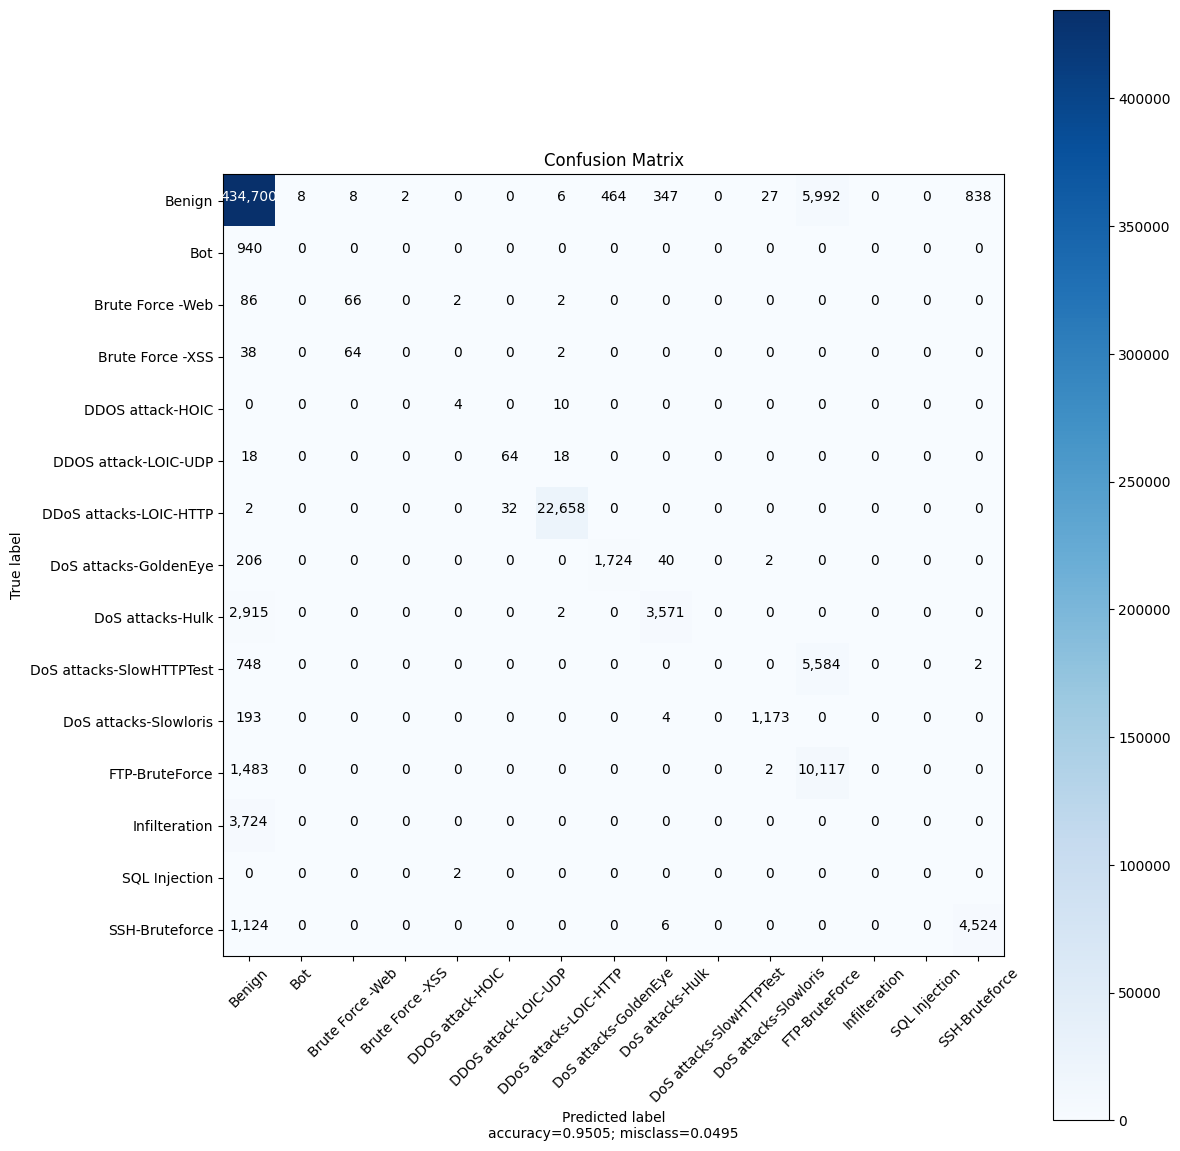

In [56]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(test_lbls, preds), 
                      normalize    = False,
                      target_names = np.unique(test_lbls),
                      title        = "Confusion Matrix")

In [57]:
test_lbls = list(test_lbls)
preds = list(preds)

In [58]:
from sklearn.metrics import classification_report
target_names = np.unique(test_lbls)
print(classification_report(test_lbls, preds, target_names=target_names, digits=4))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

                  Benign     0.9743    0.9826    0.9784    442392
                     Bot     0.0000    0.0000    0.0000       940
        Brute Force -Web     0.4783    0.4231    0.4490       156
        Brute Force -XSS     0.0000    0.0000    0.0000       104
        DDOS attack-HOIC     0.5000    0.2857    0.3636        14
    DDOS attack-LOIC-UDP     0.6667    0.6400    0.6531       100
  DDoS attacks-LOIC-HTTP     0.9982    0.9985    0.9984     22692
   DoS attacks-GoldenEye     0.7879    0.8742    0.8288      1972
        DoS attacks-Hulk     0.8999    0.5504    0.6831      6488
DoS attacks-SlowHTTPTest     0.0000    0.0000    0.0000      6334
   DoS attacks-Slowloris     0.9743    0.8562    0.9114      1370
          FTP-BruteForce     0.4664    0.8720    0.6077     11602
           Infilteration     0.0000    0.0000    0.0000      3724
           SQL Injection     0.0000    0.0000    0.0000         2
         

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
data.Label.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Label'